In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

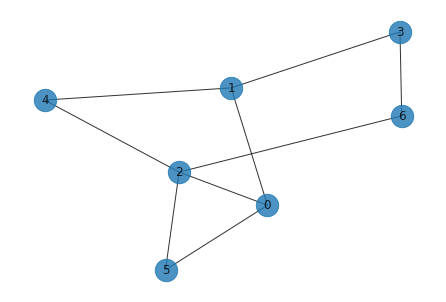

In [2]:
# CREATE OUR GRAPH
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4, 5, 6])
G.add_edges_from([(0, 1), (0, 2), (0, 5), (1, 3), (1, 4), (2, 4), (2, 5), (2, 6), (3, 6)])
my_pos = nx.spring_layout(G, seed = 100)
nx.draw(G, pos=my_pos, with_labels=True, alpha=0.8, node_size=500)

/tmp/ipykernel_257/1411741705.py:12: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense()


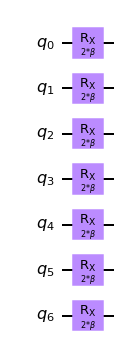

In [3]:
"""
Step 1. Create the mixing unitary H_B
"""

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

# Adjacency is essentially a matrix which tells you which nodes are
# connected. This matrix is given as a sparse matrix, so we need to
# convert it to a dense matrix
adjacency = nx.adjacency_matrix(G).todense()

nqubits = 7 # Number of vertices

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)
    
qc_mix.draw()

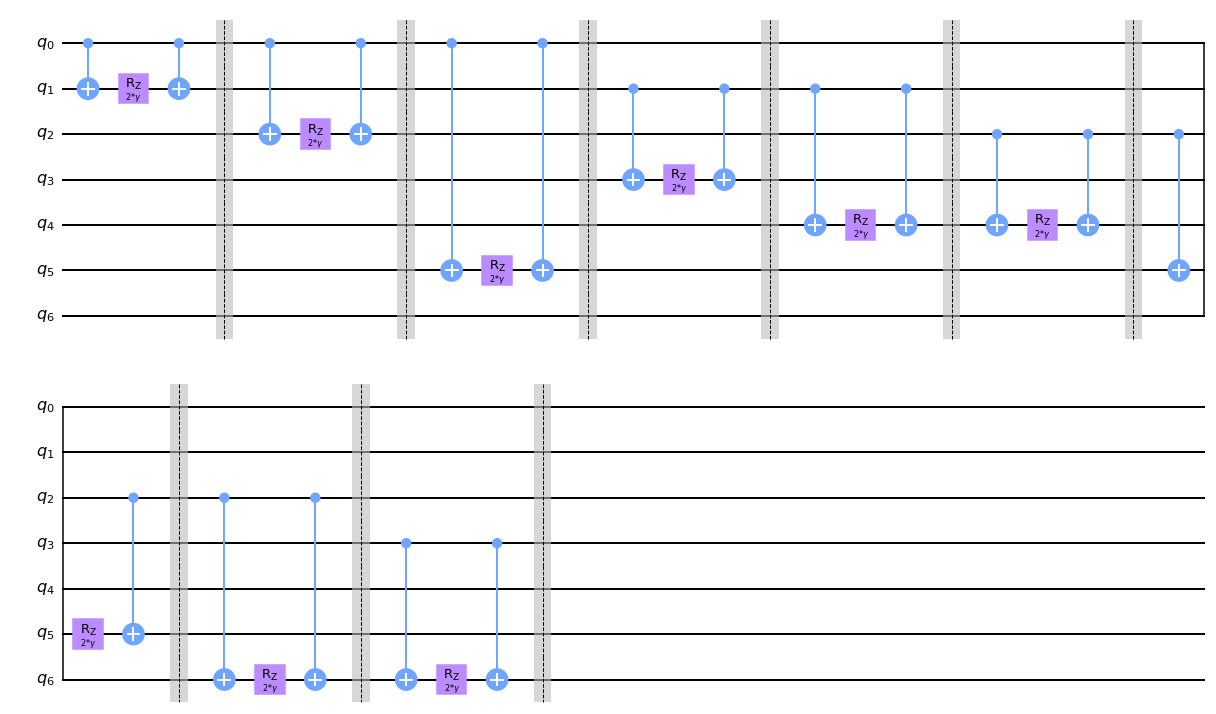

In [4]:
"""
2. Create the problem unitary H_P
"""

gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
for pair in list(G.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()
    
qc_p.decompose().draw()

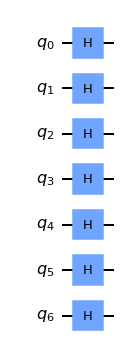

In [5]:
"""
3. Set up the initial state of the circuit
"""

qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)
    
qc_0.draw()

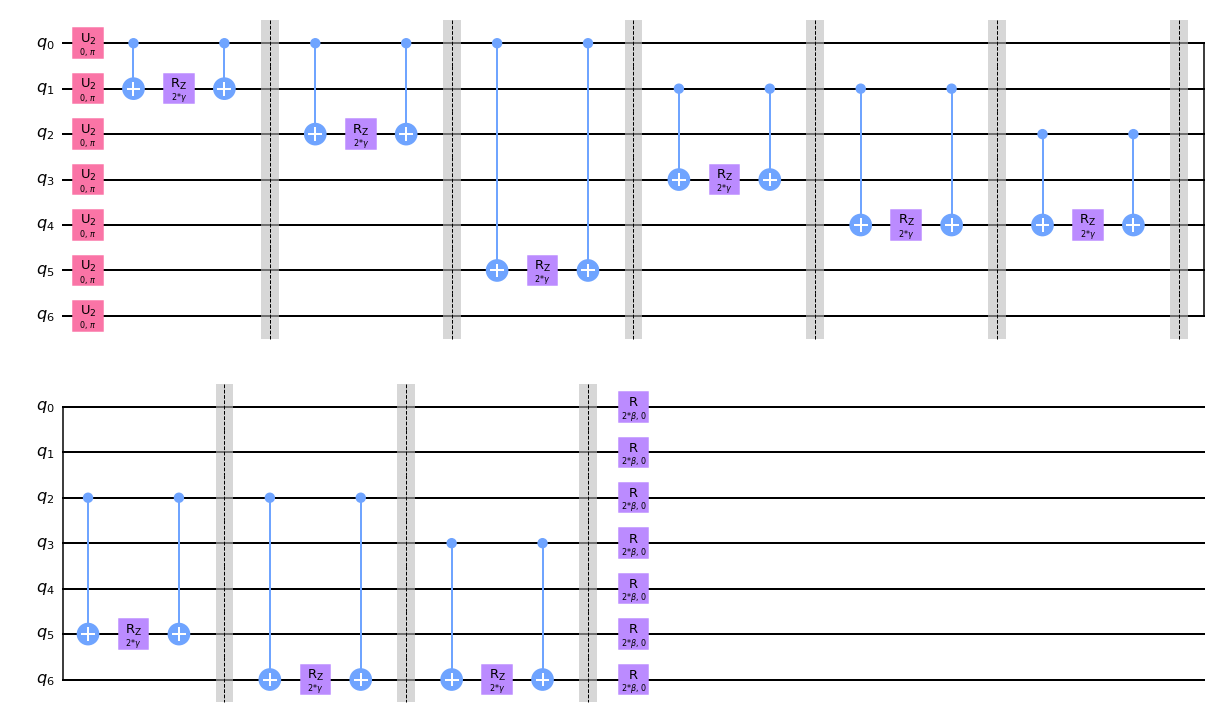

In [6]:
"""
4. Setup the QAOA circuit (initial state, then problem hamiltonian, then mixing hamiltonian)
"""

qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])

qc_qaoa.decompose().decompose().draw()

In [7]:
"""
implement our optimizer to minimize the parameters beta and gamma
"""
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring[::-1], G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, backend, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(transpile(qc, backend),nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

In [8]:
from qiskit import *

In [ ]:
from scipy.optimize import minimize

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-utokyo')
backend = Aer.get_backend('ibmq_qasm_simulator')

expectation = get_expectation(G, backend)

res = minimize(expectation, [1.0, 1.0], method='COBYLA')
res

ibmqfactory.load_account:WARNING:2022-12-07 13:51:32,168: Credentials are already in use. The existing account in the session will be replaced.


In [ ]:
from qiskit.visualization import plot_histogram

#provider = IBMQ.get_provider(hub='ibm-q-utokyo')
#backend = provider.get_backend("ibm_kawasaki")

backend.shots = 512

#previous_result = backend.retrieve("638e4f7fd65d0d019a0372ef")

qc_res = create_qaoa_circ(G, res.x)

counts = backend.run(transpile(qc_res, backend), seed_simulator=10).result().get_counts()

plot_histogram(counts)

In [10]:
max_cut_predictions = 0
max_cut = ""
for elem in counts:
    if counts[elem] > max_cut_predictions:
        max_cut = elem[::-1]
        max_cut_predictions = counts[elem]
print(f"max cut: {max_cut}")

def get_cut_value(graph, cut):
    labels = list(map(lambda elem: int(elem), list(cut)))
    cut_value = 0
    for (v1, v2) in graph.edges():
        cut_value += abs(labels[v1]-labels[v2])
    return cut_value

print("Cut value: " + str(get_cut_value(G, max_cut)))

max cut: 1011000
Cut value: 7


In [1]:
color_map = []
for node in range(len(G.nodes)):
    if max_cut[node] == '0':
        color_map.append('pink')
    else: 
        color_map.append('lightblue')
my_pos = nx.spring_layout(G, seed = 100)

plt.figure(1)
nx.draw(G, pos=my_pos, with_labels=True, alpha=0.8, node_size=500)
plt.figure(2)
nx.draw(G, pos=my_pos, node_color=color_map, with_labels=True)
print(max_cut)

Traceback (most recent call last):
  Input In [1] in <cell line: 2>
    for node in range(len(G.nodes)):
NameError: name 'G' is not defined

Use %tb to get the full traceback.


In [ ]:
"""
Running our algorithm on a real quantum machine
"""